In [1]:
import torch
import numpy as np

\begin{align}
y_1 = 2x_1^2 + 3x_2^2 -7x_3^2 -5x_1 + 11x_2 + 2x_3 + 3
\end{align}


\begin{align}
y_2 = 13x_1^2 - 11x_2^2 +7x_3^2 +2x_1 + 19x_2 - 13x_3 + 5
\end{align}

In [2]:
def generate_data(low = 0.0, high = 1.0, n=100, d=3):
    np.random.seed(73)
    return np.random.uniform(low, high, (n,d))

def quadratic_func(x, sq_coef, li_coef, bias):
    """Outputs a quadratic function with n variables  
    (based on dimension of ndarray and value of coefficients passed). 
    The number of dimensions and the number of coefficients should match"""
    sq_x = np.square(x)
    return sq_x @ sq_coef.T + x @ li_coef.T + bias
    
x = generate_data(-1.0,1.0,300, 3)

y1 = quadratic_func(x, np.array([[2,3,-7]]), np.array([[-5,11,2]]), 3)
y2 = quadratic_func(x, np.array([[13,-11,7]]), np.array([[2,19,-13]]), 5)

In [3]:
def plot_4d(x1,x2,x3,y_true,y_pred=None):
    %matplotlib inline
    %matplotlib notebook

    from matplotlib import cm
    from matplotlib import colors
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = 17, 10
    ax = plt.axes(projection='3d')
    
    max_y = np.max(y_true)
    min_y = np.min(y_true)
    
    if y_pred is not None:
        mx_pred = np.max(y_pred)
        mn_pred = np.min(y_pred)
        if mx_pred > max_y:
            max_y = mx_pred
        if mn_pred < min_y:
            min_y = mn_pred
    
    cmap = cm.get_cmap('seismic')
    norm = colors.Normalize(vmin=min_y,vmax=max_y)
    print(f'max : {max_y}  min : {min_y}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    sc1 = ax.scatter(x1, x2, x3,s=np.square(y_true[:,0] + 2),c=y_true[:,0] ,norm=norm, cmap=cmap)
    cb1 = plt.colorbar(sc1)
    cb1.set_label('y_true')
    if y_pred is not None:
        cmap2 = cm.get_cmap('PRGn')
        sc2 = ax.scatter(x1, x2, x3,s=np.square(y_pred[:,0] + 2),c=y_pred[:,0] ,norm=norm, cmap=cmap2)
        cb2 = plt.colorbar(sc2)
        cb2.set_label('y_pred')
#     sc = ax.scatter(x[:,0], x[:,1], x[:,2],s=np.square(y1[:,0] + 2),c=y1[:,0] ,norm=norm, cmap=cmap)
    plt.xlabel='x1'
    plt.ylabel='x2'
    plt.zlabel='x3'

<IPython.core.display.Javascript object>


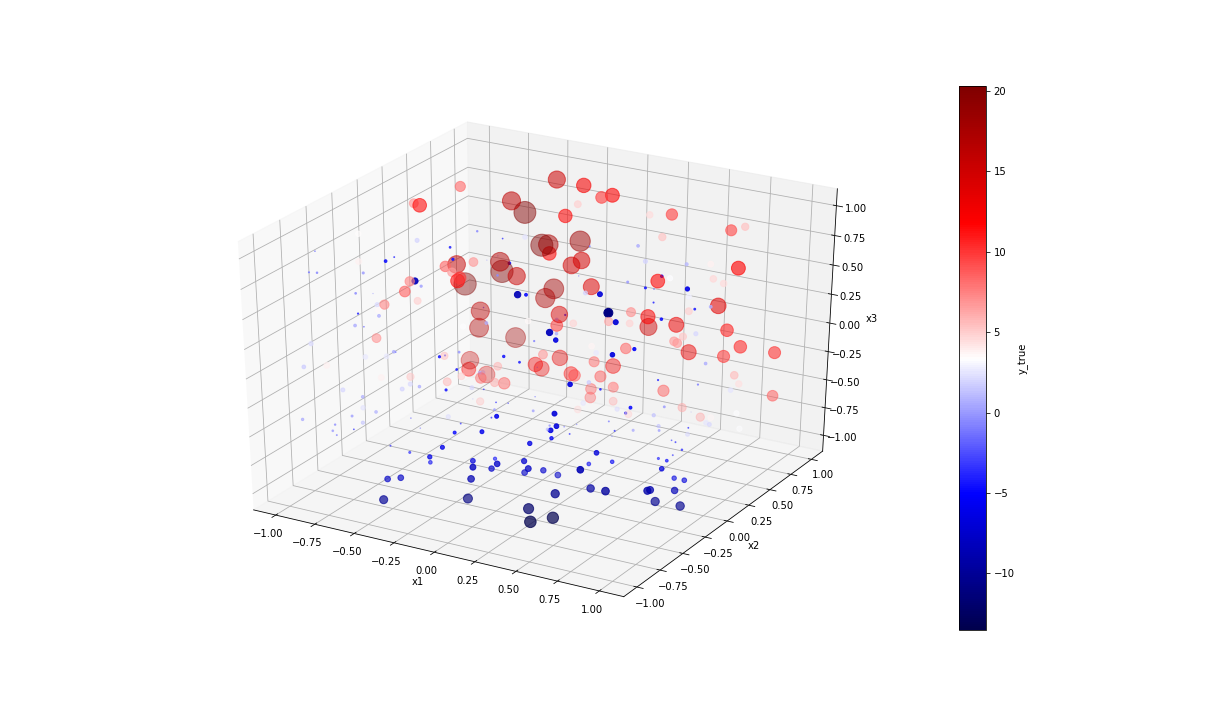

max : 20.284099794015997  min : -13.5285978007839


In [18]:
plot_4d(x[:,0], x[:,1], x[:,2], y1)

<IPython.core.display.Javascript object>


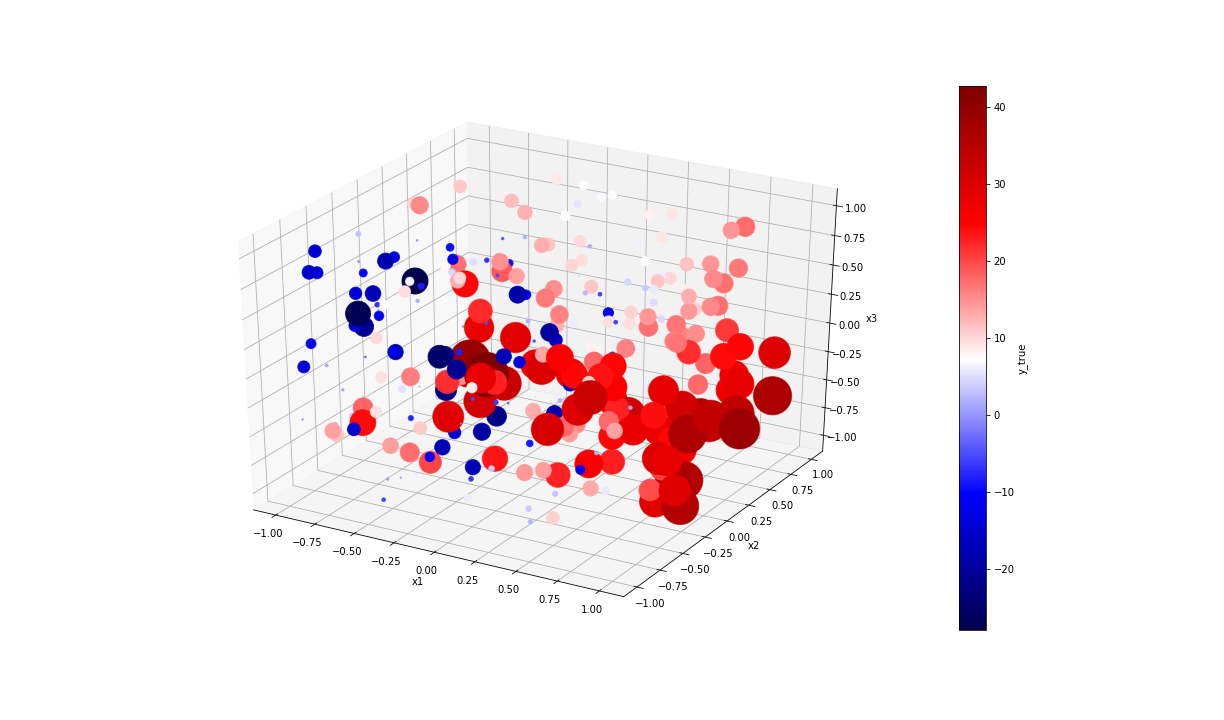

max : 42.6099130903702  min : -27.935697967500786


In [17]:
plot_4d(x[:,0], x[:,1], x[:,2], y2)

In [6]:
y_true = np.concatenate((y1,y2), axis=1)

In [7]:
print(x.shape)
print(y_true.shape)

(300, 3)
(300, 2)


## Using torch tensors

In [8]:
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()

In [9]:
class Linear:
    
    def __init__(self, input_dim, num_neurons):
        self.weights = torch.randn(input_dim, num_neurons) * np.sqrt(2/ input_dim)
        self.bias = torch.zeros(1)
        
    def __call__(self, x):
        self.x = x
        output = x @ self.weights + self.bias
        return output
    
    def backprop_gradient(self, gradient):
        # Here we are computing the gradient with which we need to adjust the weight and bias of this layer
        # using the gradient from the layer after this, and we also compute the x-gradient (the gradient with which
        # the previous layer's output needs to adjust which will get returned)
        
        # y = wx + b
        # x-gradient    dy/dx = w
        # w-gradient    dy/dw = x
        # bias gradient dy/db = 1
        #(300, 3)(3, 3)(300, 1)
        self.w_gradient = self.x.T @ gradient
        self.x_gradient = gradient @ self.weights.T
        self.bias_gradient = gradient.sum()
        return self.x_gradient
    
    def update(self, lr):
        # Updating weights and bias value calculated in backprop function
        self.weights = self.weights - lr * self.w_gradient
        self.bias = self.bias - lr * self.bias_gradient
        
class Relu:
    def __call__(self, input):
        self.input = input
        self.output = torch.clip(self.input, 0, None)
        return self.output
    
    def backprop_gradient(self, gradient):
        self.input_gradient = (self.input > 0) * gradient
        return self.input_gradient
    
class MSE:
    def __call__(self, y_true, y_pred):
        self.y_pred = y_pred
        self.y_true = y_true
        # MSE = (delta_y1^2/n + delta_y2^2/n + ...delta_yn^2/n)
        return ((self.y_pred - self.y_true)**2).mean()
    
    def backprop_gradient(self):
        # At this level we want to find out what effect the predicted value has on the cost function,
        #or in other words how much sensitive a cost function is to small change in predicted output,
        # which translates mathematically as finding the derivative of cost function with respect to predicted output
        n = self.y_true.shape[0]
        #derivative of MSE wrt output delta_y = 2*(delta_y1 + delta_y2 + ...)/n
        self.gradient = 2 * (self.y_pred - self.y_true)/n
#         print(f'MSE Backward_Gradient ==> Y_shape {self.y_pred.shape} gradient_shape {self.gradient.shape}')
        return self.gradient


class Model:
    def __init__(self, input_dim):
        self.linear_ip = Linear(input_dim, 5)
        self.relu1   = Relu()
        self.linear2 = Linear(5, 4)
        self.relu2   = Relu()
        self.linear_op = Linear(4, 2)
        
    def __call__(self,x):
        l1 = self.linear_ip(x)
#         print(f'l1 shape : {l1.shape}')
        r1 = self.relu1(l1)
#         print(f'r1 shape : {r1.shape}')
        l2 = self.linear2(r1)
#         print(f'l2 shape : {l2.shape}')
        r2 = self.relu2(l2)
        l3 = self.linear_op(r2)
        return l3
    
    def backward(self, op_gradient):
        l3_grad = self.linear_op.backprop_gradient(op_gradient)
        r2_grad = self.relu2.backprop_gradient(l3_grad)
        l2_grad = self.linear2.backprop_gradient(r2_grad)
        r1_grad = self.relu1.backprop_gradient(l2_grad)
        l1_grad = self.linear_ip.backprop_gradient(r1_grad)
        return l1_grad
    
    def update(self, lr):
        self.linear_op.update(lr)
        self.linear2.update(lr)
        self.linear_ip.update(lr)

In [10]:
def fit(x, y_true, model, loss, lr=0.01, num_epoch=1000):
    
    for epoch in range(num_epoch):
        y_pred = model(x)
        loss_val = loss(y_true, y_pred)
        print(f'Epoch {epoch}, loss {loss_val}')
        model.backward(loss.backprop_gradient())
        model.update(lr)

In [11]:
loss = MSE()
model = Model(x_tensor.shape[1])
fit(x_tensor, y_true_tensor, model, loss)

Epoch 0, loss 181.04049682617188
Epoch 1, loss 178.1749267578125
Epoch 2, loss 175.79994201660156
Epoch 3, loss 173.69398498535156
Epoch 4, loss 171.68528747558594
Epoch 5, loss 169.63934326171875
Epoch 6, loss 167.3452606201172
Epoch 7, loss 164.6352081298828
Epoch 8, loss 161.09747314453125
Epoch 9, loss 156.0939483642578
Epoch 10, loss 148.1616973876953
Epoch 11, loss 135.01046752929688
Epoch 12, loss 114.06377410888672
Epoch 13, loss 86.46601867675781
Epoch 14, loss 66.3234634399414
Epoch 15, loss 58.5905647277832
Epoch 16, loss 52.35924530029297
Epoch 17, loss 46.83555603027344
Epoch 18, loss 42.01029968261719
Epoch 19, loss 37.84782409667969
Epoch 20, loss 34.14943313598633
Epoch 21, loss 30.95277976989746
Epoch 22, loss 28.069608688354492
Epoch 23, loss 25.528636932373047
Epoch 24, loss 23.364553451538086
Epoch 25, loss 21.379343032836914
Epoch 26, loss 19.652576446533203
Epoch 27, loss 18.394962310791016
Epoch 28, loss 17.497608184814453
Epoch 29, loss 16.832963943481445
Epoch 

Epoch 287, loss 7.757248401641846
Epoch 288, loss 6.723742485046387
Epoch 289, loss 7.8127336502075195
Epoch 290, loss 6.733242988586426
Epoch 291, loss 7.841884613037109
Epoch 292, loss 6.748434066772461
Epoch 293, loss 7.791253089904785
Epoch 294, loss 6.718165874481201
Epoch 295, loss 7.69399881362915
Epoch 296, loss 6.773459434509277
Epoch 297, loss 7.701246738433838
Epoch 298, loss 6.886573791503906
Epoch 299, loss 7.721316814422607
Epoch 300, loss 7.051954746246338
Epoch 301, loss 7.677545547485352
Epoch 302, loss 7.153841972351074
Epoch 303, loss 7.540020942687988
Epoch 304, loss 7.109081268310547
Epoch 305, loss 7.271562576293945
Epoch 306, loss 6.9569854736328125
Epoch 307, loss 6.9311604499816895
Epoch 308, loss 6.704195976257324
Epoch 309, loss 6.526346206665039
Epoch 310, loss 6.384453296661377
Epoch 311, loss 6.142027854919434
Epoch 312, loss 6.050515651702881
Epoch 313, loss 5.79364013671875
Epoch 314, loss 5.731548309326172
Epoch 315, loss 5.511190414428711
Epoch 316, lo

Epoch 644, loss 5.822936534881592
Epoch 645, loss 6.4067840576171875
Epoch 646, loss 5.893224239349365
Epoch 647, loss 6.579551696777344
Epoch 648, loss 6.036346435546875
Epoch 649, loss 6.767545700073242
Epoch 650, loss 6.198420524597168
Epoch 651, loss 6.99029541015625
Epoch 652, loss 6.416728496551514
Epoch 653, loss 7.331996917724609
Epoch 654, loss 6.7141876220703125
Epoch 655, loss 7.682321548461914
Epoch 656, loss 6.941197872161865
Epoch 657, loss 7.840017318725586
Epoch 658, loss 7.0316667556762695
Epoch 659, loss 7.8333821296691895
Epoch 660, loss 6.91903829574585
Epoch 661, loss 7.521091461181641
Epoch 662, loss 6.575575828552246
Epoch 663, loss 7.087956428527832
Epoch 664, loss 6.366328716278076
Epoch 665, loss 6.854247093200684
Epoch 666, loss 6.205770492553711
Epoch 667, loss 6.794144153594971
Epoch 668, loss 6.272055149078369
Epoch 669, loss 7.044984340667725
Epoch 670, loss 6.66370964050293
Epoch 671, loss 7.625738143920898
Epoch 672, loss 7.290670394897461
Epoch 673, lo

In [12]:
y_pred_tensor = model(x_tensor)

In [13]:
y_pred = y_pred_tensor.numpy()
y1_pred = y_pred[:,0].reshape(300,1)
y2_pred = y_pred[:,1].reshape(300,1)

<IPython.core.display.Javascript object>


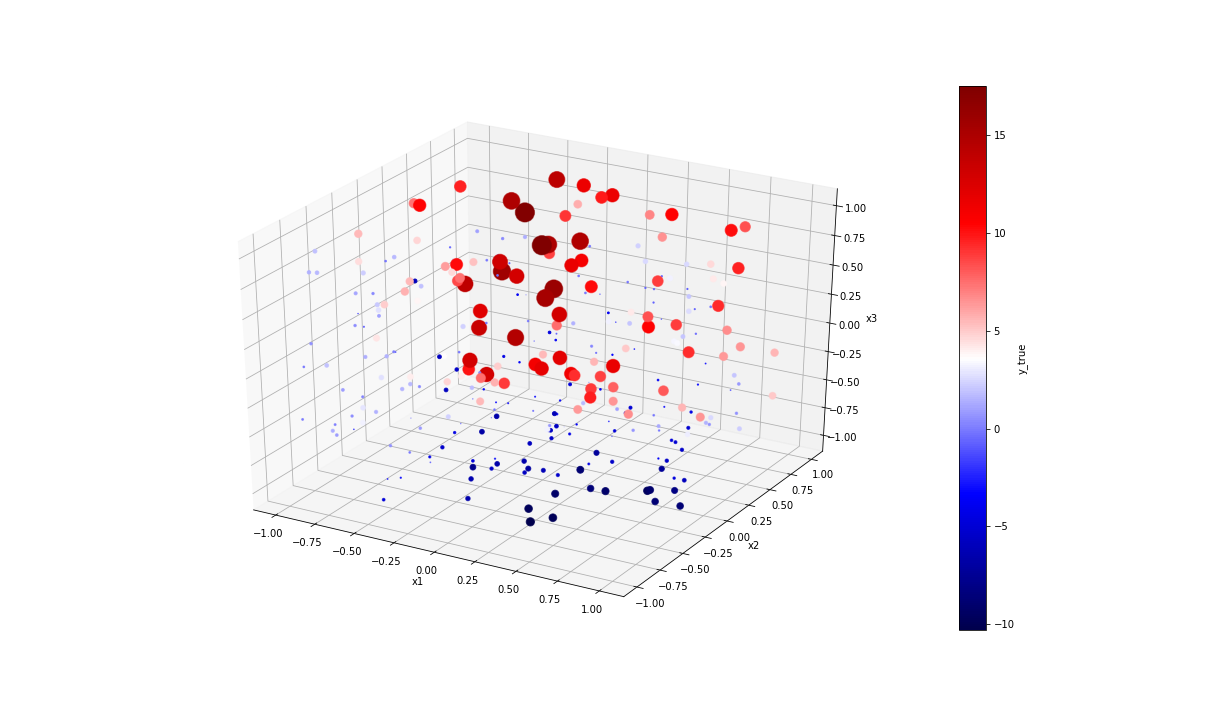

max : 17.46334457397461  min : -10.284074783325195


In [16]:
plot_4d(x[:,0], x[:,1], x[:,2], y1_pred)

<IPython.core.display.Javascript object>


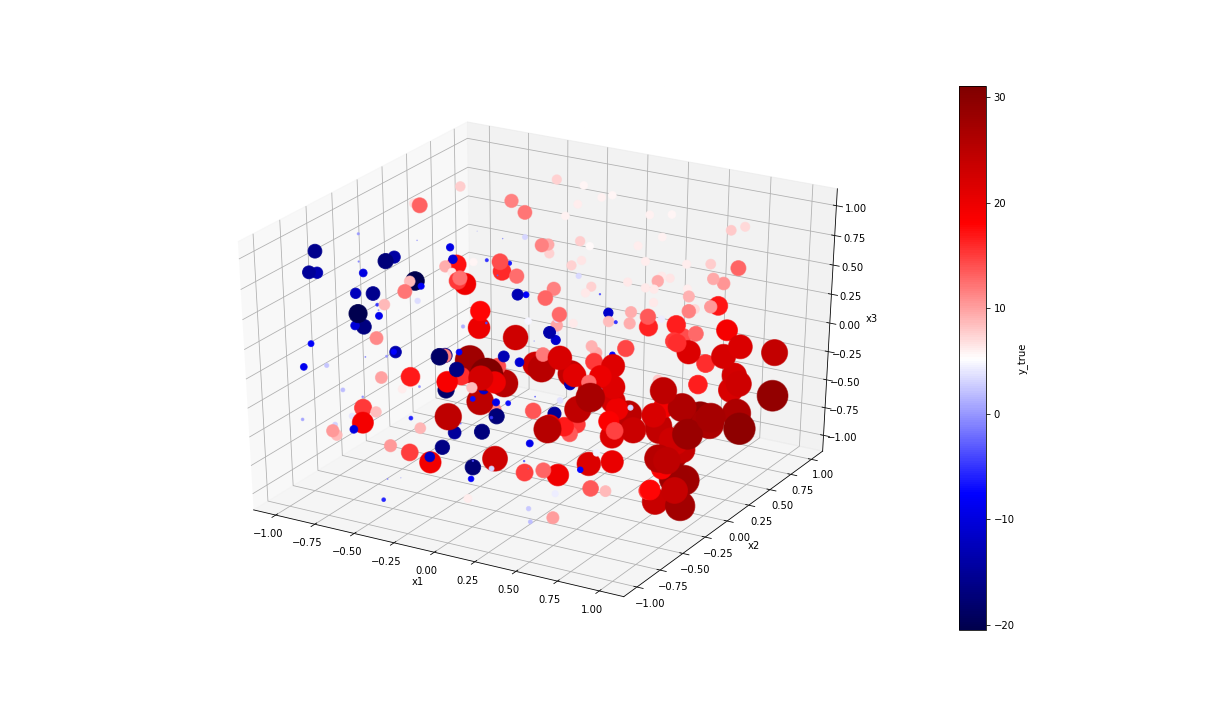

max : 31.03471565246582  min : -20.496566772460938


In [15]:
plot_4d(x[:,0], x[:,1], x[:,2], y2_pred)